In [1]:
# Useful libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

from torch.cuda import is_available

import librosa

In [2]:
# Modified version of LeNet5 from lecture to support 432x288 RGB images
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.name = "LeNet5"
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(115920, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class LeNet5m(nn.Module):
    def __init__(self):
        super(LeNet5m, self).__init__()
        self.name = "LeNet5"
        self.conv1 = nn.Conv2d(3, 6, kernel_size=11, stride=4, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Modified version of AlexNet from lecture to support 432x228 RGB images
# https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(6144, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# Version with padding

class AlexNetP(nn.Module):
    def __init__(self):
        super(AlexNetP, self).__init__()
        self.name = "AlexNetP"
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3 , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(24576, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
t = LeNet5m()
params = 0
for param in t.parameters():
    print(param.numel())
    params += param.numel()
print(params)

2178
6
2400
16
14586240
120
10080
84
840
10
14601974


In [5]:
# Dataset in google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
# Copy zip file from google drive here and extract it
# https://stackoverflow.com/questions/3451111/unzipping-files-in-python
import os
import zipfile
!cp "/content/drive/MyDrive/Colab Notebooks/APS360/Project/IMData.zip" "/content/"
with zipfile.ZipFile("IMData.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

In [29]:
"""path = 'dataset/'

train_set_features = torchvision.datasets.DatasetFolder(path + 'TrainFeatures', loader=torch.load, extensions=('.tensor'))
valid_set_features = torchvision.datasets.DatasetFolder(path + 'ValidFeatures', loader=torch.load, extensions=('.tensor'))
test_set_features = torchvision.datasets.DatasetFolder(path + 'TestFeatures', loader=torch.load, extensions=('.tensor'))
print("train set size: ", len(train_set_features))
print("validation set size: ", len(valid_set_features))
print("test set size: ", len(test_set_features))"""

# credit: https://stackoverflow.com/questions/60173417/pytorch-default-dataloader-gets-stuck-for-large-image-classification-training-se

import os
import pathlib

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, folder: str, klass: int, extension: str = "png", transform = None):
        self._data = pathlib.Path(root) / folder
        self.klass = klass
        self.extension = extension
        self.transform = transform
        # Only calculate once how many files are in this folder
        # Could be passed as argument if you precalculate it somehow
        # e.g. ls | wc -l on Linux
        self._length = sum(1 for entry in os.listdir(self._data))

    def __len__(self):
        # No need to recalculate this value every time
        return self._length

    def __getitem__(self, index):
        # images always follow [0, n-1], so you access them directly
        return self.transform(Image.open(self._data / "{}.{}".format(str(index), self.extension)).convert('RGB')), self.klass

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

impath = "/content/IMData"
dataset = (
    ImageDataset(impath, "Arabic", 0, "png", transform)
    + ImageDataset(impath, "English", 1, "png", transform)
    + ImageDataset(impath, "French", 2, "png", transform)
    + ImageDataset(impath, "Hindi", 3, "png", transform)
    + ImageDataset(impath, "Indonesian", 4, "png", transform)
    + ImageDataset(impath, "Japanese", 5, "png", transform)
    + ImageDataset(impath, "Mandarin-CN", 6, "png", transform)
    + ImageDataset(impath, "Portuguese", 7, "png", transform)
    + ImageDataset(impath, "Russian", 8, "png", transform)
    + ImageDataset(impath, "Spanish", 9, "png", transform)
)

In [7]:
def get_data_loader(dataset, batch_size):
    # Load training data
    trainset = dataset

    # Get the list of indices to sample from
    relevant_indices = list(range(len(trainset)))
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.6) # split at 60%
    split2 = int(len(relevant_indices) * 0.9)
    
    # Split into training, validation, and testing indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split], relevant_indices[split:split2], relevant_indices[split2:]
    print("Train: {}, val: {}, test: {}".format(len(relevant_train_indices), len(relevant_val_indices), len(relevant_test_indices)))
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=2, sampler=train_sampler,
                                               pin_memory=True)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             num_workers=2, sampler=val_sampler,
                                             pin_memory=True)
    
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=2, sampler=test_sampler,
                                              pin_memory=True)
   
    return train_loader, val_loader, test_loader

In [8]:
# Same as lab 2
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# Same as lab 2 but with different code for calculating error
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda(0)
            labels = labels.cuda(0)

        outputs = net(inputs)
        loss = criterion(outputs, labels.long())

        # In this function and train_net I need to use a different method to 
        # compute the error. The output of the net, when put through a sigmoid
        # (which the CrossEntropyLoss function does automatically), returns
        # a tensor with a number for each classification. The "prediction"
        # of the network is the index which corresponds to the highest number
        # In order to check the prediction against the label, I find the index
        # of the maximum element in each prediction tensor using max
        # then simply loop through the result checking them against the 
        # labels, adding up the number of times the model was incorrect

        iz, ix = nn.Sigmoid()(outputs).max(dim=1)
        corr = 0
        for indx in range(len(ix)):
            if ix[indx] != labels[indx]:
                corr += 1
        total_err += int(corr)
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_net(dataset, net, batch_size=64, learning_rate=0.01, num_epochs=100):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(dataset, batch_size)

    # Define the Loss function and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            if i % 100 == 0:
                print("Epoch {}: done {} batches".format(epoch, i))
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda(0)
                labels = labels.cuda(0)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # See comment in function evaluate() for more detail on below code
            # and how it computes the error
            iz, ix = nn.Sigmoid()(outputs).max(dim=1)
            corr = 0
            for indx in range(len(ix)):
                if ix[indx] != labels[indx]:
                    corr += 1

            total_train_err += int(corr)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} | "+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/"
        torch.save(net.state_dict(), results_path + "checkpoints/" + model_path)
    print('Finished Training')

    # Write the train/test loss/err into CSV file for plotting later
    # epochs = np.arange(1, num_epochs + 1)
    model_path = get_model_name(net.name, batch_size, learning_rate, num_epochs)
    np.savetxt(results_path + "{}_train_err.csv".format(model_path), train_err)
    np.savetxt(results_path + "{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt(results_path + "{}_val_err.csv".format(model_path), val_err)
    np.savetxt(results_path + "{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
def main():
    net = LeNet5()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=256, learning_rate=0.01, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 25 batches
Epoch 0: done 50 batches
Epoch 0: done 75 batches
Epoch 0: done 100 batches
Epoch 0: done 125 batches
Epoch 0: done 150 batches
Epoch 0: done 175 batches
Epoch 0: done 200 batches
Epoch 0: done 225 batches
Epoch 0: done 250 batches
Epoch 0: done 275 batches
Epoch 1: Train err: 0.5396818699632927, Train loss: 1.5467469587171678 | Validation err: 0.3488973897389739, Validation loss: 0.9413445915494646
Epoch 1: done 0 batches
Epoch 1: done 25 batches
Epoch 1: done 50 batches
Epoch 1: done 75 batches
Epoch 1: done 100 batches
Epoch 1: done 125 batches
Epoch 1: done 150 batches
Epoch 1: done 175 batches
Epoch 1: done 200 batches
Epoch 1: done 225 batches
Epoch 1: done 250 batches
Epoch 1: done 275 batches
Epoch 2: Train err: 0.2881594306850625, Train loss: 0.7871539408354451 | Validation err: 0.2811656165616562, Validation loss: 0.7449707899774823
Epoch 2: done 0 batches
Epoch 2: done 25 batches
Epoch 2: do

In [ ]:
def main():
    net = AlexNet()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=128, learning_rate=0.05, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 1: Train err: 0.8015132976105087, Train loss: 2.174834040857905 | Validation err: 0.7351485148514851, Validation loss: 1.9216315167290823
Epoch 1: done 0 batches


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae6c371710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae6c371710>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/c

Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 2: Train err: 0.5765438870371151, Train loss: 1.3912730056176084 | Validation err: 0.48481098109810983, Validation loss: 1.2298641221863882
Epoch 2: done 0 batches
Epoch 2: done 100 batches
Epoch 2: done 200 batches
Epoch 2: done 300 batches
Epoch 2: done 400 batches
Epoch 2: done 500 batches
Epoch 3: Train err: 0.4443694358887811, Train loss: 1.1098462840635999 | Validation err: 0.3885013501350135, Validation loss: 1.0150849282741548
Epoch 3: done 0 batches
Epoch 3: done 100 batches
Epoch 3: done 200 batches
Epoch 3: done 300 batches
Epoch 3: done 400 batches
Epoch 3: done 500 batches
Epoch 4: Train err: 0.37546938947723724, Train loss: 0.9439547631165964 | Validation err: 0.3346084608460846, Validation loss: 0.8797412608351026
Epoch 4: done 0 batches
Epoch 4: done 100 batches
Epoch 4: done 200 batches
Epoch 4: done 300 batches
Epoch 4: done 400 batch

In [ ]:
def main():
    net = AlexNet()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=64, learning_rate=0.02, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 0: done 600 batches
Epoch 0: done 700 batches
Epoch 0: done 800 batches
Epoch 0: done 900 batches
Epoch 0: done 1000 batches
Epoch 0: done 1100 batches
Epoch 1: Train err: 0.7212072627034021, Train loss: 1.805149833969336 | Validation err: 0.5839333933393339, Validation loss: 1.3967356879076511
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 1: done 600 batches
Epoch 1: done 700 batches
Epoch 1: done 800 batches
Epoch 1: done 900 batches
Epoch 1: done 1000 batches
Epoch 1: done 1100 batches
Epoch 2: Train err: 0.47872804241733824, Train loss: 1.1976335205868704 | Validation err: 0.4011026102610261, Validation loss: 1.0194779107038923
Epoch 2: done 0 batches
Epoch 2: done 100 batches


In [ ]:
def main():
    net = AlexNet()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=64, learning_rate=0.01, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 0: done 600 batches
Epoch 0: done 700 batches
Epoch 0: done 800 batches
Epoch 0: done 900 batches
Epoch 0: done 1000 batches
Epoch 0: done 1100 batches
Epoch 1: Train err: 0.7606008185308637, Train loss: 1.9437655424020186 | Validation err: 0.6074482448244825, Validation loss: 1.4268805680515098
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 1: done 600 batches
Epoch 1: done 700 batches
Epoch 1: done 800 batches
Epoch 1: done 900 batches
Epoch 1: done 1000 batches
Epoch 1: done 1100 batches
Epoch 2: Train err: 0.5164760980549344, Train loss: 1.2723969534428456 | Validation err: 0.439018901890189, Validation loss: 1.1082858396091049
Epoch 2: done 0 batches
Epoch 2: done 100 batches
E

In [ ]:
def main():
    net = LeNet5()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=256, learning_rate=0.001, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 1: Train err: 0.7798545771627077, Train loss: 2.1644635826563663 | Validation err: 0.6526777677767777, Validation loss: 1.953768399783543
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 2: Train err: 0.6030265952210174, Train loss: 1.8159211758229372 | Validation err: 0.554005400540054, Validation loss: 1.6922163418361118
Epoch 2: done 0 batches
Epoch 2: done 100 batches
Epoch 2: done 200 batches
Epoch 3: Train err: 0.49913505759250665, Train loss: 1.5518173489639226 | Validation err: 0.4464446444644464, Validation loss: 1.4428648233413697
Epoch 3: done 0 batches
Epoch 3: done 100 batches
Epoch 3: done 200 batches
Epoch 4: Train err: 0.4327102935178544, Train loss: 1.3631587615973657 | Validation err: 0.4173042304230423, Validation loss: 1.2979847294943674
Epoch 4: done 0 batches
Epoch 4: done 100 batches
Epoch 4: done 200 batches
Epoch

In [ ]:
def main():
    net = AlexNet()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=64, learning_rate=0.0001, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 0: done 600 batches
Epoch 0: done 700 batches
Epoch 0: done 800 batches
Epoch 0: done 900 batches
Epoch 0: done 1000 batches
Epoch 0: done 1100 batches
Epoch 1: Train err: 0.5634783342475002, Train loss: 1.4279102400334218 | Validation err: 0.4383438343834383, Validation loss: 1.1267435863721285
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 1: done 600 batches
Epoch 1: done 700 batches
Epoch 1: done 800 batches
Epoch 1: done 900 batches
Epoch 1: done 1000 batches
Epoch 1: done 1100 batches
Epoch 2: Train err: 0.39027889118602593, Train loss: 1.0043201730339297 | Validation err: 0.3402340234023402, Validation loss: 0.8881546280366911
Epoch 2: done 0 batches
Epoch 2: done 100 batches

KeyboardInterrupt: ignored

In [ ]:
def main():
    net = AlexNetP()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=64, learning_rate=0.0001, num_epochs=30)

if __name__ == '__main__':
    main()

Train: 53327, val: 26664, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 0: done 600 batches
Epoch 0: done 700 batches
Epoch 0: done 800 batches
Epoch 1: Train err: 0.5175427081965983, Train loss: 1.3422637533941428 | Validation err: 0.36603660366036606, Validation loss: 0.9631776488084587
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 1: done 600 batches
Epoch 1: done 700 batches
Epoch 1: done 800 batches
Epoch 2: Train err: 0.2777017270800908, Train loss: 0.7364202230025253 | Validation err: 0.23777377737773778, Validation loss: 0.6413958462165128
Epoch 2: done 0 batches
Epoch 2: done 100 batches
Epoch 2: done 200 batches
Epoch 2: done 300 batches
Epoch 2: done 400 batches
Epoch 2: done 500 batches
Epoch 2: done 600 batches
Epoch 2: done 700 batches
E

In [ ]:
def main():
    net = LeNet5m()
    if torch.cuda.is_available():
        net.cuda(0)
    train_net(dataset, net, batch_size=64, learning_rate=0.001, num_epochs=20)

if __name__ == '__main__':
    main()

Train: 53327, val: 26664, test: 8888
Epoch 0: done 0 batches
Epoch 0: done 100 batches
Epoch 0: done 200 batches
Epoch 0: done 300 batches
Epoch 0: done 400 batches
Epoch 0: done 500 batches
Epoch 0: done 600 batches
Epoch 0: done 700 batches
Epoch 0: done 800 batches


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa83e5ff7a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa83e5ff7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _sh

Epoch 1: Train err: 0.4796632100061882, Train loss: 1.306406388465735 | Validation err: 0.3391839183918392, Validation loss: 0.9225179848911094
Epoch 1: done 0 batches
Epoch 1: done 100 batches
Epoch 1: done 200 batches
Epoch 1: done 300 batches
Epoch 1: done 400 batches
Epoch 1: done 500 batches
Epoch 1: done 600 batches
Epoch 1: done 700 batches
Epoch 1: done 800 batches
Epoch 2: Train err: 0.29185965833442723, Train loss: 0.7939186100836852 | Validation err: 0.29695469546954695, Validation loss: 0.801548568607806
Epoch 2: done 0 batches
Epoch 2: done 100 batches
Epoch 2: done 200 batches
Epoch 2: done 300 batches
Epoch 2: done 400 batches
Epoch 2: done 500 batches
Epoch 2: done 600 batches
Epoch 2: done 700 batches
Epoch 2: done 800 batches
Epoch 3: Train err: 0.2189322482044743, Train loss: 0.606566141370675 | Validation err: 0.27077707770777076, Validation loss: 0.7515194444633502
Epoch 3: done 0 batches
Epoch 3: done 100 batches
Epoch 3: done 200 batches
Epoch 3: done 300 batches

KeyboardInterrupt: ignored

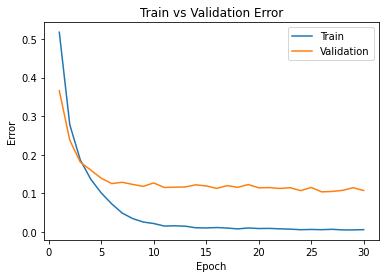

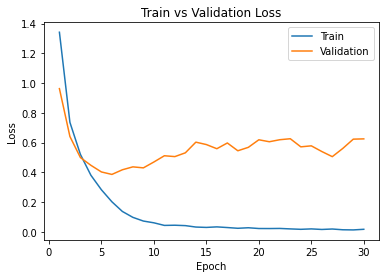

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/"
plot_training_curve(results_path + get_model_name("AlexNetP", 64, 0.0001, 30))

In [ ]:
def main():
    test_net = AlexNetP()
    results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/checkpoints/"
    test_net.load_state_dict(torch.load(results_path + get_model_name("AlexNetP", 64, 0.0001, 6)))
    train_loader, val_loader, test_loader = get_data_loader(dataset, 64)
    if torch.cuda.is_available():
        test_net.cuda(0)
    test_err, test_loss = evaluate(test_net, test_loader, nn.CrossEntropyLoss())
    print("Test err: {}, test loss: {}".format(test_err, test_loss))

if __name__ == "__main__":
    main()

Train: 53327, val: 26664, test: 8888
Test err: 0.13265076507650764, test loss: 0.4400130833010022


In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(net, loader):
    y_true = []
    y_pred = []
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda(0)
            labels = labels.cuda(0)
        outputs = net(inputs)
        iz, ix = nn.Sigmoid()(outputs.cpu()).max(dim=1)

        y_true.append(labels.cpu())
        y_pred.append(ix)

    y_true_tensor = torch.cat(y_true)
    y_pred_tensor = torch.cat(y_pred)

    confusion = confusion_matrix(y_true_tensor, y_pred_tensor)
    return confusion

def main():
    train_loader, val_loader, test_loader = get_data_loader(dataset, 64)
    test_net = AlexNetP()
    if torch.cuda.is_available():
        test_net.cuda(0)
    results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/checkpoints/"
    test_net.load_state_dict(torch.load(results_path + get_model_name("AlexNetP", 64, 0.0001, 6)))
    print(evaluate_confusion_matrix(test_net, test_loader))

if __name__ == "__main__":
    main()

Train: 53327, val: 26664, test: 8888


KeyboardInterrupt: ignored

In [9]:
langs = ["Arabic", "English", "French", "Hindi", "Indonesian", "Japanese", "Mandarin-CN", "Portuguese", "Russian", "Spanish"]
def predict(net, file_path):
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    im = transform(Image.open(file_path).convert('RGB'))
    input = torch.unsqueeze(im, 0)
    output = net(input)
    print(output)
    iz, ix = nn.Sigmoid()(output).max(dim=1)
    print(langs[ix[0]])

In [91]:
test_net = AlexNetP()
results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/checkpoints/"
test_net.load_state_dict(torch.load(results_path + get_model_name("AlexNetP", 64, 0.0001, 6)))
predict(test_net, "/content/drive/MyDrive/Colab Notebooks/APS360/Project/aric.png")



tensor([[ -7.2999,  11.9731,   3.4184,  -1.5519, -11.4335, -11.0926,   0.5456,
         -12.8109,  -5.6563,  -6.0887]], grad_fn=<AddmmBackward0>)
English
